## CAN YOU PREDICT THE PRODUCT BACKORDERS??

<img src = "Backorder.png", height=100,width=100>



Material backorder is a common SUPPLY CHAIN PROBLEM,
impacting an inventory system service level and effectiveness.
Identifying parts with the highest chances of shortage prior
its occurrence can present a high opportunity to improve an
overall company’s performance.

In this project, a MACHINE LEARNING
CLASSIFIER is investigated in order to propose a predictive model
for this imbalanced class problem, where the relative frequency of
items that go on backorder is rare when compared to items
that do not. Specific metrics such as area under the Receiver
Operator Characteristic and precision-recall curves, sampling
techniques and ensemble learning are employed in this particular
task. Results are presented and future scope is discussed.

Image Source: https://www.microchannel.com.au/company-blog/january-2017/inventory-management-how-to-minimise-your-backorde

#### IMPORTING REQUIRED PACKAGES

In [101]:
from timeit import default_timer as timer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sb
from sklearn.metrics import classification_report , roc_auc_score, roc_curve, auc , precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.inspection import permutation_importance

# from experimental import enable_iterative_imputer
# from sklearn.experimental import enable_iterative_imputer #Works only in sklearn 0.21 (not stable; experimental package)
# from sklearn.impute import IterativeImputer   #Works only in sklearn 0.21 (not stable; experimental package)
# from missingpy import KNNImputer

#### GETTING A VIEW OF OUR DATA 

In [63]:
start = timer()
train= pd.read_csv("C:\\Python36\\Kaggle_Training_Dataset.csv")
train.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,2079834,23,NaN,0,0,0,0,0,0,0,...,0,-99.0,-99.0,0,Yes,No,No,Yes,No,No
1,2079835,2,NaN,0,0,0,0,0,0,0,...,0,-99.0,-99.0,0,Yes,No,No,Yes,No,No
2,2079836,6,NaN,0,0,0,0,0,0,0,...,0,-99.0,-99.0,0,Yes,No,No,Yes,No,No
3,2079837,87,NaN,0,0,0,0,0,0,3,...,0,-99.0,-99.0,0,No,No,No,Yes,No,No
4,2080337,315,NaN,0,0,0,0,0,1,3,...,0,-99.0,-99.0,0,Yes,No,No,No,No,No


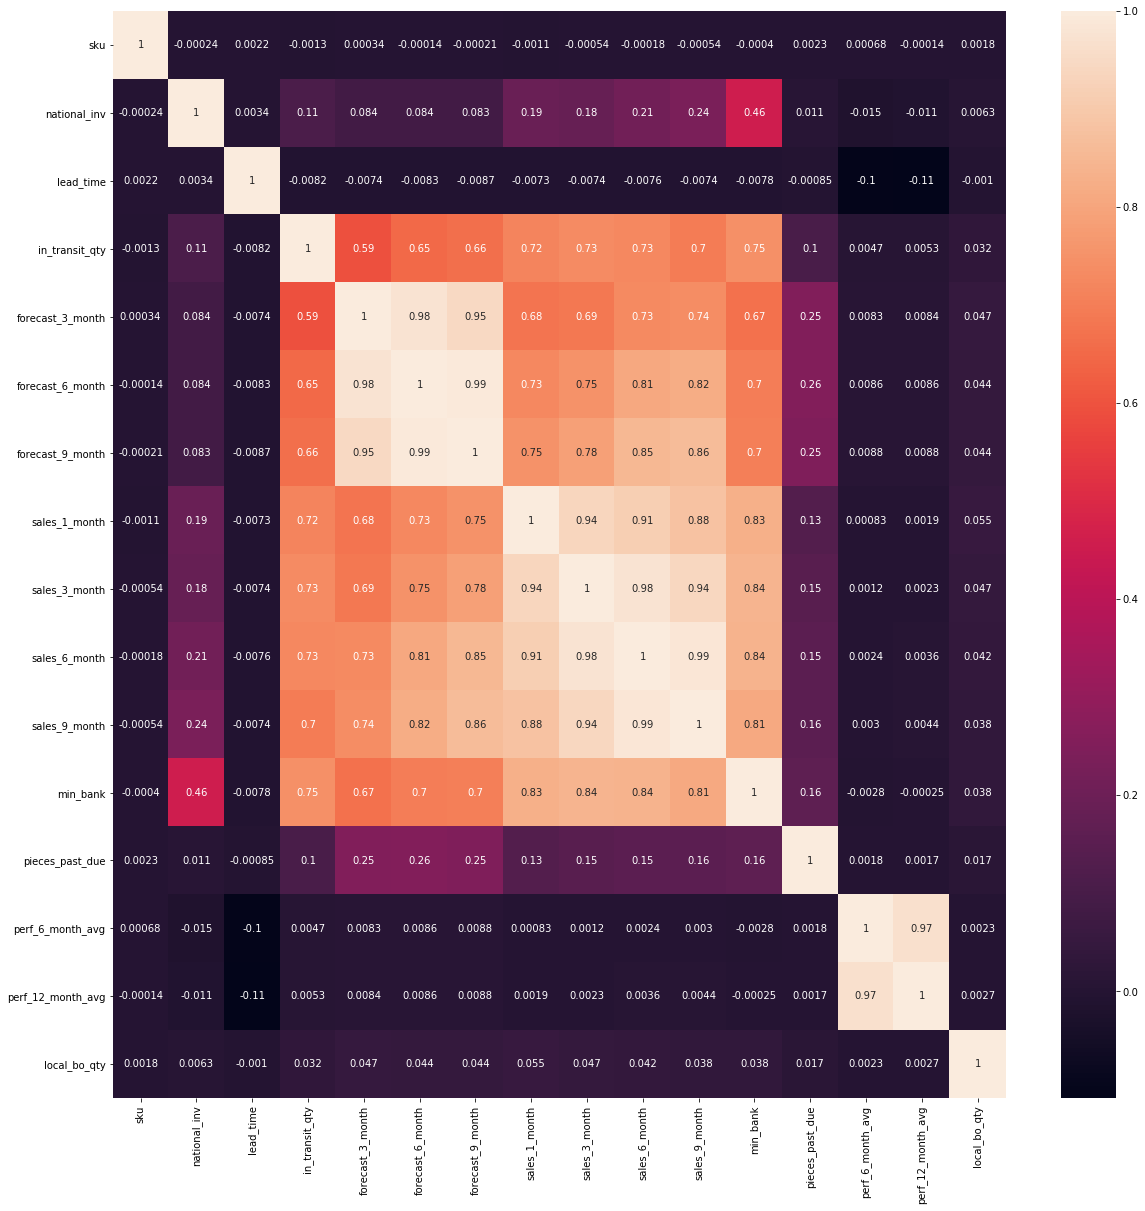

In [66]:
corrMatrix = train.corr()
sb.heatmap(corrMatrix, annot=True)
plt.show()
fig = plt.gcf()
fig.set_size_inches(20, 20)

#### DATA CLEANINIG

Activities Performed:
1. Preparing our DataFrame (Dropping the "sku" column as it would add no value to our model)
2. Transforming data into appropriate format (Machine Learning models do not take data in the string format)
3. Imputing missing values (Disucssion about Mean Imputation and other sophisticated imputation techniques)
4. Treating Outliers
5. Handling Imbalanced Data

#### Preparing our DataFrame & Data Transformation (Steps 1 & 2)

In [67]:
train = train.drop(["sku"], axis= 1)
le = LabelEncoder()        # Converting categorical variables into dummy variables

train["went_on_backorder"] = le.fit_transform(train["went_on_backorder"])
train["potential_issue"] = le.fit_transform(train["potential_issue"])
train["deck_risk"] = le.fit_transform(train["deck_risk"])
train["oe_constraint"] = le.fit_transform(train["oe_constraint"])
train["ppap_risk"] = le.fit_transform(train["ppap_risk"])
train["stop_auto_buy"] = le.fit_transform(train["stop_auto_buy"])
train["rev_stop"] = le.fit_transform(train["rev_stop"])
train.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,23,NaN,0,0,0,0,0,0,0,0,...,0,-99.0,-99.0,0,1,0,0,1,0,0
1,2,NaN,0,0,0,0,0,0,0,0,...,0,-99.0,-99.0,0,1,0,0,1,0,0
2,6,NaN,0,0,0,0,0,0,0,0,...,0,-99.0,-99.0,0,1,0,0,1,0,0
3,87,NaN,0,0,0,0,0,0,3,5,...,0,-99.0,-99.0,0,0,0,0,1,0,0
4,315,NaN,0,0,0,0,0,1,3,11,...,0,-99.0,-99.0,0,1,0,0,0,0,0


#### Getting a Sense of Positive Class Count (Minority Class) i.e. Products that went on Backorder

In [68]:
neg, pos = np.bincount(train['went_on_backorder'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 1693050
    Positive: 10914 (0.64% of total)



#### Imputing missing values and Treating outliers (Steps 3 & 4)

Discussion:

Having missing values in a dataset is very common. While some Machine Learning Algorithms are good at handling missing values, there are some algorithms that do not. Hence, it becomes important for us to understand how to handle missing values. There are a lot of ways to deal with missing data, like:
1. Deleting the rows with missing values in them 
2. Imputing missing values
    2.a Univariate Imputation
    2.b Multivariate Imputation


2.a Univariate Imputation: 
One type of imputation algorithm is univariate, which imputes values in the i-th feature dimension using only non-missing values in that feature dimension.

2.b Multivariate Imputation: 
Multivariate imputation algorithms use the entire set of available feature dimensions to estimate the missing values

Source: https://scikit-learn.org/stable/modules/impute.html#impute

In [69]:
#Imputing missing values  (Many sophisticated ways are possible, however since current sklearn version doesn't support them, used mean imputer)

train.lead_time.fillna(round(train.lead_time.mean()), inplace=True)
train.head()


# Converting lead time into integer according to SMOTE's requirement. 
train.lead_time = train.lead_time.astype(int)
print(train.dtypes)


#Handling the -0.99 values in the perf_12_month_avg & perf_6_month_avg feature
train1 = train[train['perf_12_month_avg'] != -99.0]
train2= train[train['perf_6_month_avg'] != -99.0]


perf_12_month_avg_Mean = round(train1.perf_12_month_avg.mean(), 2)   #Replacing -0.99 with the mean
perf_6_month_avg_Mean = round(train2.perf_6_month_avg.mean(),2)     #Replacing -0.99 with the mean
train.perf_12_month_avg = train.perf_12_month_avg.replace(to_replace = -99.0, value = perf_12_month_avg_Mean)    #Replacing -0.99 with the mean
train.perf_6_month_avg = train.perf_6_month_avg.replace(to_replace = -99.0, value = perf_6_month_avg_Mean)       #Replacing -0.99 with the mean


print(train.perf_12_month_avg.value_counts())
print(train.perf_6_month_avg.value_counts())

national_inv           int64
lead_time              int32
in_transit_qty         int64
forecast_3_month       int64
forecast_6_month       int64
forecast_9_month       int64
sales_1_month          int64
sales_3_month          int64
sales_6_month          int64
sales_9_month          int64
min_bank               int64
potential_issue        int32
pieces_past_due        int64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty           int64
deck_risk              int32
oe_constraint          int32
ppap_risk              int32
stop_auto_buy          int32
rev_stop               int32
went_on_backorder      int32
dtype: object
0.99    146466
0.77    138623
0.98     87223
0.96     69429
0.79     61370
0.78     60120
0.97     55330
0.95     48492
0.66     48210
1.00     45823
0.80     40338
0.90     39744
0.94     37797
0.91     35910
0.75     35107
0.00     34327
0.82     33596
0.92     30481
0.67     29330
0.48     28967
0.81     27727
0.87     27654
0.93     27221
0.8

In [70]:
train.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,23,8,0,0,0,0,0,0,0,0,...,0,0.77,0.77,0,1,0,0,1,0,0
1,2,8,0,0,0,0,0,0,0,0,...,0,0.77,0.77,0,1,0,0,1,0,0
2,6,8,0,0,0,0,0,0,0,0,...,0,0.77,0.77,0,1,0,0,1,0,0
3,87,8,0,0,0,0,0,0,3,5,...,0,0.77,0.77,0,0,0,0,1,0,0
4,315,8,0,0,0,0,0,1,3,11,...,0,0.77,0.77,0,1,0,0,0,0,0


#### Helper Functions for splitting our dataset, trainng a RF model and, plotting ROC

In [71]:
def split_dataset(train, train_percentage, X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_percentage, random_state= 1)
    return X_train, X_test, Y_train, Y_test

def Random_Forest_Classifier(features, label):

    clf = RandomForestClassifier(n_jobs = -1, n_estimators = 1000, class_weight = 'balanced')
    clf.fit(features, label)
    return clf


def roc_curve_acc(Y_test, prediction):            ##Reciever Operating charectaristic is a measure of errors in our model; Summarizes the performance of the classifier over all possible thresholds
    false_positive_rate,true_positive_rate, thresholds = roc_curve(Y_test, prediction)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title('Reciever Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, color='cyan', label=f'AUC = {round(roc_auc, 2)}')
    plt.legend(loc= 'lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.0])
    plt.ylim([0.0,1.0])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

In [72]:
X= train.drop(['went_on_backorder'], axis=1)
Y= train['went_on_backorder']
X_train, X_test, Y_train, Y_test = split_dataset(train, 0.8, X, Y)

print ("X_train_shape: " , X_train.shape)
print ("X_test_shape: " , X_test.shape)
print ("Y_train_shape: " , Y_train.shape)
print ("Y_test_shape: " , X_test.shape)    

X_train_shape:  (1354440, 21)
X_test_shape:  (338610, 21)
Y_train_shape:  (1354440,)
Y_test_shape:  (338610, 21)


#### SMOTE: Synthetic Minority Oversampling Technique

The challenge of working with imbalanced datasets is that most machine learning techniques will ignore, and in turn have poor performance on, the minority class, although typically it is performance on the minority class that is most important.

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

-Source: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

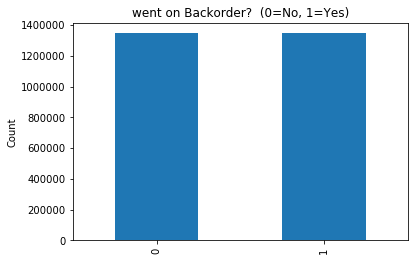

In [76]:
from imblearn.over_sampling import SMOTE          #SMOTE - Synthetic Minority Oversampling Technique. 
over_sampler = SMOTE(random_state=0)
X_train, Y_train = over_sampler.fit_sample(X_train, Y_train) #oversampling of the training sets to get unbaised results. 

plt.figure()
pd.Series(Y_train).value_counts().sort_index().plot(kind= 'bar')    #plotting of the oversampling data
plt.ylabel("Count")
plt.title('went on Backorder?  (0=No, 1=Yes)')
plt.show()

In [ ]:
print(X_train.shape)
print(Y_train.shape)

#### Training the Random Forest Model and Finding Important Features

Discussion:
Understanding the feature importance scores given by Random Forest:

The scikit-learn Random Forest feature importance and R's default Random Forest feature importance strategies are biased.
Firstly, feature selection based on impurity reduction is biased towards preferring variables with more categories. Secondly, when the dataset has two (or more) correlated features, then from the point of view of the model, any of these correlated features can be used as the predictor, with no concrete preference of one over the others. But once one of them is used, the importance of others is significantly reduced since effectively the impurity they can remove is already removed by the first feature. As a consequence, they will have a lower reported importance. This is not an issue when we want to use feature selection to reduce overfitting, since it makes sense to remove features that are mostly duplicated by other features. But when interpreting the data, it can lead to the incorrect conclusion that one of the variables is a strong predictor while the others in the same group are unimportant, while actually they are very close in terms of their relationship with the response variable.

Source: https://blog.datadive.net/selecting-good-features-part-iii-random-forests/

 

Trained Model :  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


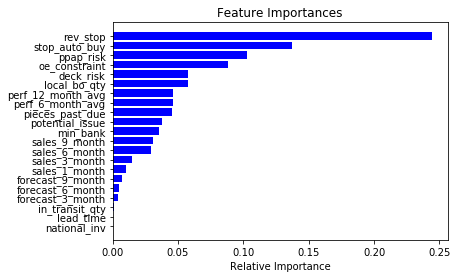

In [77]:
trained_model = Random_Forest_Classifier(X_train, Y_train) # Model trained on all features
print ("Trained Model : ", trained_model)    #To have a look at the classifier parameters   

#Finding important Features
features = list(train.head(0))
importances = trained_model.feature_importances_
indices = np.argsort(importances)

#PLotting Feature Scores
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features, rotation = 'horizontal')
plt.xlabel('Relative Importance')
plt.show()

#### Observations

As we can see, the Random Forest feature importance scores suggest that categorical features like 'rev_stop', 'stop_auto_buy', 'ppap_risk' and 'oe_constraint' are all important features.

#### Permutation Importance

In [ ]:
# result = permutation_importance(trained_model, X_test, Y_test, n_repeats=10,
#                                 random_state=42, n_jobs=-1)
# sorted_idx = result.importances_mean.argsort()

# fig, ax = plt.subplots()
# ax.barh(range(len(indices)), result.importances[sorted_idx].T,
#            vert=False, labels=X_test.columns[sorted_idx])
# ax.set_title("Permutation Importances (test set)")
# fig.tight_layout()
# plt.show()

In [79]:
prediction = trained_model.predict(X_test)
print ("Train Accuracy :: ", accuracy_score(Y_train, trained_model.predict(X_train)))
print ("Test Accuracy  :: ", accuracy_score(Y_test, prediction))
print ('roc_auc_score:' , roc_auc_score(Y_test, prediction))
print("Confusion Matrix for Training:", confusion_matrix(Y_train, trained_model.predict(X_train))) 

Train Accuracy ::  0.9970263971808923
Test Accuracy  ::  0.9908862703405097
roc_auc_score: 0.7969684059385092
Confusion Matrix for Training: [[1343282    2392]
 [   5611 1340063]]


#### Training Model by Cross validation

In [102]:
# cross_validation_score = cross_validate(trained_model, X_train, Y_train,scoring='f1', cv=10)
# print(sorted(cross_validation_score.keys()))  
# cross_validation_score['test_score'].mean()


KeyboardInterrupt



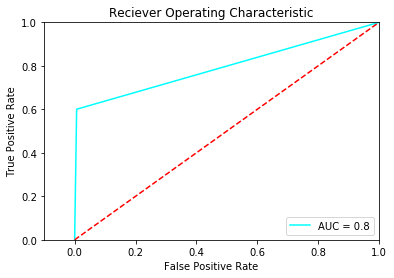

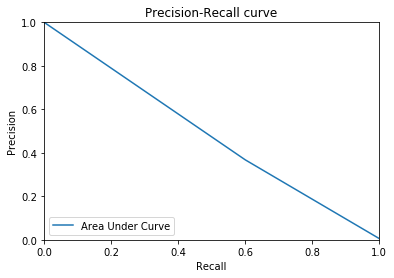

confusion Matrix:: [[334244   2218]
 [   858   1290]]
9473.8416227 Seconds


In [58]:
#Plotting the ROC curve
roc_curve_acc(Y_test, prediction)  
precision, recall, thresholds = precision_recall_curve(Y_test, prediction)      #Check for errors and accuracy of our model.
area = auc(recall, precision)              # precision is the ratio tp / (tp + fp) ; recall is the ratio tp / (tp + fn)
plt.figure()
plt.plot(recall, precision, label = 'Area Under Curve')             
plt.legend(loc= 'lower left')
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel ('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.show()                  # The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
                            # The recall is intuitively the ability of the classifier to find all the positive samples.
print ('confusion Matrix::' , confusion_matrix(Y_test, prediction))

duration = timer() - start
print (duration, "Seconds")

#### Retraining our model on Selective Features

<Figure size 1440x1440 with 0 Axes>

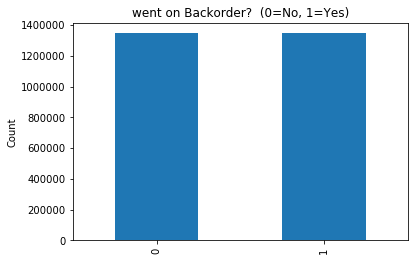

In [85]:
# New DataFrame
selective_features = train.drop(["forecast_3_month", "forecast_9_month", "sales_6_month","sales_9_month","perf_12_month_avg"], axis = 1)

#New Split 
X_selective= selective_features.drop(['went_on_backorder'], axis=1)
Y_selective= selective_features['went_on_backorder']
X_train_s, X_test_s, Y_train_s, Y_test_s = split_dataset(selective_features, 0.8, X_selective, Y_selective)

#Oversampling
over_sampler = SMOTE(random_state=0)
X_train_s, Y_train_s = over_sampler.fit_sample(X_train_s, Y_train_s) #oversampling of the training sets to get unbaised results. 

plt.figure()
pd.Series(Y_train_s).value_counts().sort_index().plot(kind= 'bar')    #plotting of the oversampling data
plt.ylabel("Count")
plt.title('went on Backorder?  (0=No, 1=Yes)')
plt.show()


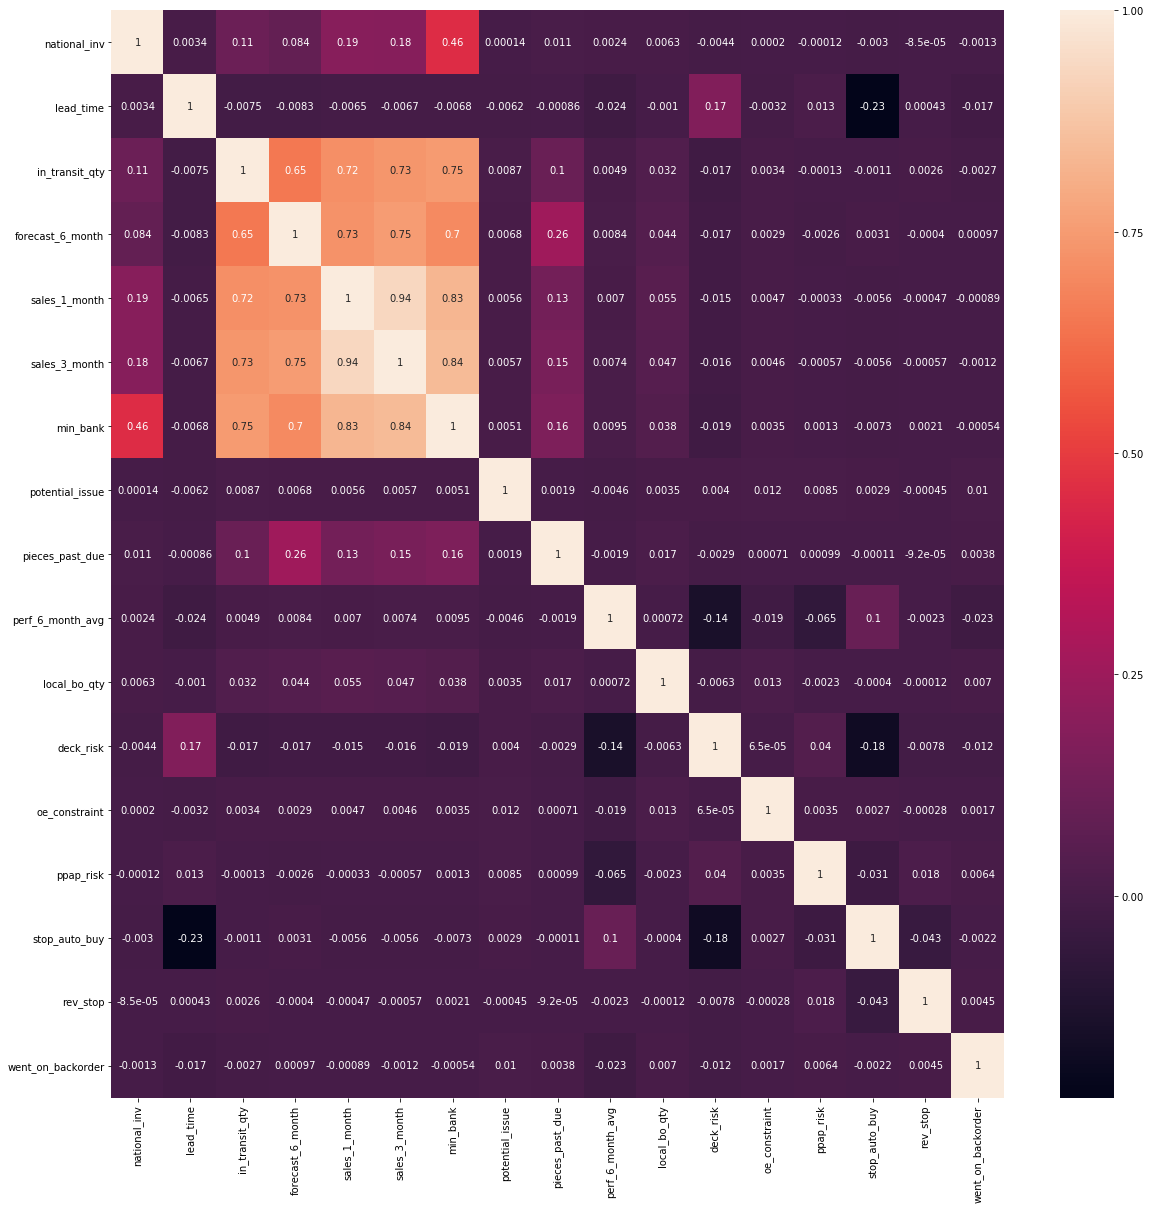

In [84]:
corrMatrix = selective_features.corr()
sb.heatmap(corrMatrix, annot=True)
plt.show()
fig = plt.gcf()
fig.set_size_inches(20, 20)

In [61]:
trained_model_s = Random_Forest_Classifier(X_train_s, Y_train_s) 
print ("Trained Model : ", trained_model_s)    #To have a look at the classifier parameters   

#Finding important Features
features = list(selective_features.head(0))
importances = trained_model_s.feature_importances_
indices = np.argsort(importances)

#PLotting Feature Scores
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features, rotation = 'horizontal')
plt.xlabel('Relative Importance')
plt.show()

KeyboardInterrupt: 

In [ ]:
prediction_s = trained_model_s.predict(X_test_s)
print ("Train Accuracy :: ", accuracy_score(Y_train_s, trained_model_s.predict(X_train_s)))
print ("Test Accuracy  :: ", accuracy_score(Y_test_s, prediction_s))
print ('roc_auc_score:' , roc_auc_score(Y_test_s, prediction_s))

In [ ]:
#Plotting the ROC curve
roc_curve_acc(Y_test_s, prediction)  
precision, recall, thresholds = precision_recall_curve(Y_test, prediction)      #Check for errors and accuracy of our model.
area = auc(recall, precision)              # precision is the ratio tp / (tp + fp) ; recall is the ratio tp / (tp + fn)
plt.figure()
plt.plot(recall, precision, label = 'Area Under Curve')             
plt.legend(loc= 'lower left')
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel ('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.show()                  # The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
                            # The recall is intuitively the ability of the classifier to find all the positive samples.
print ('confusion Matrix::' , confusion_matrix(Y_test, prediction))

duration = timer() - start
print (duration, "Seconds")

#### Testing the Model

In [151]:
test= pd.read_excel("C:\\Python36\\Kaggle_Test_Dataset.xlsx")

In [196]:
#Lets test the model on test file.
test["went_on_backorder"] = le.fit_transform(test["went_on_backorder"])
test["potential_issue"] = le.fit_transform(test["potential_issue"])
test["deck_risk"] = le.fit_transform(test["deck_risk"])
test["oe_constraint"] = le.fit_transform(test["oe_constraint"])
test["ppap_risk"] = le.fit_transform(test["ppap_risk"])
test["stop_auto_buy"] = le.fit_transform(test["stop_auto_buy"])
test["rev_stop"] = le.fit_transform(test["rev_stop"])

test = test.drop(['sku'], axis= 1)

#Filling NA values in Lead_Time with mean
test.lead_time.fillna(round(test.lead_time.mean()), inplace=True)
test.head()
# test.dtypes

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,39,8.0,0,0,0,0,0,0,0,0,...,0,0.77,0.78,0,1,0,0,1,0,0
1,93,8.0,0,0,0,0,0,0,0,0,...,0,0.77,0.78,0,0,0,0,1,0,0
2,0,15.0,0,0,0,0,0,0,0,0,...,0,0.80,0.77,0,0,0,0,1,0,0
3,4,8.0,0,0,0,0,0,0,1,1,...,0,0.77,0.78,0,1,0,0,1,0,0
4,61,2.0,0,0,0,0,0,0,0,0,...,0,0.77,0.78,0,0,0,0,1,0,0


In [197]:
#Handling the -0.99 values in the perf_12_month_avg & perf_6_month_avg feature
test1 = test[test['perf_12_month_avg'] != -99.0]
test2= test[test['perf_6_month_avg'] != -99.0]


perf_12_month_avg_Mean_test = round(test1.perf_12_month_avg.mean(), 2)   #Replacing -0.99 with the mean
perf_6_month_avg_Mean_test = round(test2.perf_6_month_avg.mean(),2)     #Replacing -0.99 with the mean
test.perf_12_month_avg = test.perf_12_month_avg.replace(to_replace = -99.0, value = perf_12_month_avg_Mean_test)    #Replacing -0.99 with the mean
test.perf_6_month_avg = test.perf_6_month_avg.replace(to_replace = -99.0, value = perf_6_month_avg_Mean_test)       #Replacing -0.99 with the mean


print(test.perf_12_month_avg.value_counts())
print(test.perf_6_month_avg.value_counts())

0.99    23125
0.78    19586
0.80    14441
0.98    11254
0.96    10598
0.75     9015
0.97     7341
1.00     6697
0.94     6645
0.95     6466
0.67     6394
0.79     6292
0.91     5853
0.90     5698
0.65     5655
0.85     5565
0.66     5331
0.82     4945
0.00     4936
0.48     4824
0.84     4679
0.74     4197
0.86     3717
0.93     3483
0.69     3477
0.92     3322
0.87     2634
0.89     2624
0.35     2363
0.88     2226
        ...  
0.29      288
0.56      287
0.21      253
0.54      238
0.10      237
0.31      217
0.42      205
0.36      194
0.34      191
0.05      188
0.28      182
0.44      177
0.11      169
0.07      155
0.01      137
0.03      135
0.58      132
0.14      130
0.27      129
0.13      124
0.06      123
0.19      101
0.22       91
0.46       91
0.23       88
0.02       83
0.38       78
0.24       50
0.15       46
0.04       35
Name: perf_12_month_avg, Length: 101, dtype: int64
0.99    21002
0.77    19694
1.00    18247
0.71    12002
0.98    11223
0.80    10095
0.63     85

In [81]:
Xtest= test.drop(['went_on_backorder'], axis=1)
Ytest= test['went_on_backorder']

# Ytest.value_counts()
# print(Xtest.head())
# print(Ytest.head())


prediction_Testing_Data = trained_model.predict(Xtest)
# print ('Actual Outcome::', Ytest, 'Predicted Outcome::', prediction_Testing_Data)
print ("Test Data Accuracy  :: ", accuracy_score(Ytest, prediction_Testing_Data))
print ('confusion Matrix::' , confusion_matrix(Ytest, prediction_Testing_Data))

plot_confusion_matrix(trained_model, Xtest, Ytest)
plt.show()
# ConfusionMatrixDisplay(confusion_matrix(Ytest, prediction_Testing_Data), [0,1]).plot()
# plt.show()

NameError: name 'test' is not defined

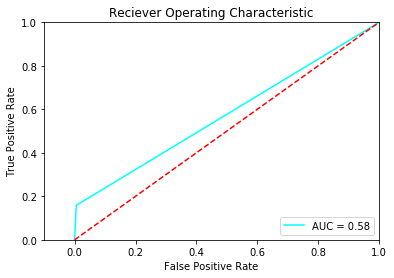

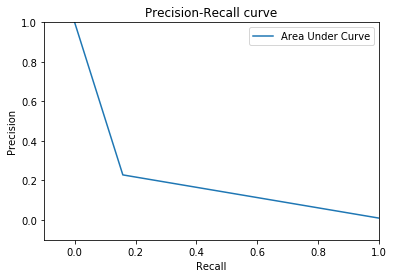

In [199]:
roc_curve_acc(Ytest, prediction_Testing_Data)

precision, recall, thresholds = precision_recall_curve(Ytest, prediction_Testing_Data)      #Check for errors and accuracy of our model.

area = auc(recall, precision)              # precision is the ratio tp / (tp + fp) ; recall is the ratio tp / (tp + fn)
plt.figure()
plt.plot(recall, precision, label = 'Area Under Curve')             
plt.legend(loc= 'upper right')
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel ('Precision')
plt.ylim([-0.1, 1.0])
plt.xlim([-0.1, 1.0])
plt.show()                  # The precision is 


#### Improvement Points


 0.  Remove biasing of the data. Create equal samples of "Yes" & "No" so that the classifier won't show biased results.            *DONE
 1.  Draw a correlation Matrix to get an idea about feature dependencies. (Works only for numeric data set. For categorical data use CART) 
 2.  Select only those features and make a new data frame.
 3.  Alternate way of doing the above step is by recording the feature importance score using sklearn.
 4.  Retrain your model and compare accuracies.
 5.  Pickling of model is necessary to avoid re-training time.
 5.  play with the default parameters of sklearn for RF classifier. (eg: Look for results when you increse the number of trees from 10 (default) to 100 or more.)
 6.  Learn about 'gini' error.
 7.  Refer mini project code for improvement as well. (personal Note)
 8. Check if : The ROC goes up after dropping sku from test set, after removing NAN values from lead_time & cleaning 6 & 12 month average feature.
 9. Develope a NN model to test if the results are better.

## Training the model without handling outliers/cleaning

In [186]:
train_plain = pd.read_csv("C:\\Python36\\Kaggle_Training_Dataset.csv")
train_plain.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,2079834,23,NaN,0,0,0,0,0,0,0,...,0,-99.0,-99.0,0,Yes,No,No,Yes,No,No
1,2079835,2,NaN,0,0,0,0,0,0,0,...,0,-99.0,-99.0,0,Yes,No,No,Yes,No,No
2,2079836,6,NaN,0,0,0,0,0,0,0,...,0,-99.0,-99.0,0,Yes,No,No,Yes,No,No
3,2079837,87,NaN,0,0,0,0,0,0,3,...,0,-99.0,-99.0,0,No,No,No,Yes,No,No
4,2080337,315,NaN,0,0,0,0,0,1,3,...,0,-99.0,-99.0,0,Yes,No,No,No,No,No


In [187]:
train_no_sku = train_plain.drop("sku", axis = 1)  #DF with no sku. Use train_plain as main DataFrame with all columns

In [189]:
le = LabelEncoder()        # Converting categorical variables into dummy variables

train_no_sku["went_on_backorder"] = le.fit_transform(train_no_sku["went_on_backorder"])
train_no_sku["potential_issue"] = le.fit_transform(train_no_sku["potential_issue"])
train_no_sku["deck_risk"] = le.fit_transform(train_no_sku["deck_risk"])
train_no_sku["oe_constraint"] = le.fit_transform(train_no_sku["oe_constraint"])
train_no_sku["ppap_risk"] = le.fit_transform(train_no_sku["ppap_risk"])
train_no_sku["stop_auto_buy"] = le.fit_transform(train_no_sku["stop_auto_buy"])
train_no_sku["rev_stop"] = le.fit_transform(train_no_sku["rev_stop"])
train_no_sku.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,23,NaN,0,0,0,0,0,0,0,0,...,0,-99.0,-99.0,0,1,0,0,1,0,0
1,2,NaN,0,0,0,0,0,0,0,0,...,0,-99.0,-99.0,0,1,0,0,1,0,0
2,6,NaN,0,0,0,0,0,0,0,0,...,0,-99.0,-99.0,0,1,0,0,1,0,0
3,87,NaN,0,0,0,0,0,0,3,5,...,0,-99.0,-99.0,0,0,0,0,1,0,0
4,315,NaN,0,0,0,0,0,1,3,11,...,0,-99.0,-99.0,0,1,0,0,0,0,0


In [193]:
train_no_sku.lead_time.fillna(round(train_no_sku.lead_time.mean()), inplace=True)
train_no_sku.head()

# Converting lead time into integer according to SMOTE's requirement. 

# train.isnull().sum()
# train_no_sku.lead_time = train_no_sku.lead_time.astype(int)
# print(train_plain.dtypes)

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,23,8.0,0,0,0,0,0,0,0,0,...,0,-99.0,-99.0,0,1,0,0,1,0,0
1,2,8.0,0,0,0,0,0,0,0,0,...,0,-99.0,-99.0,0,1,0,0,1,0,0
2,6,8.0,0,0,0,0,0,0,0,0,...,0,-99.0,-99.0,0,1,0,0,1,0,0
3,87,8.0,0,0,0,0,0,0,3,5,...,0,-99.0,-99.0,0,0,0,0,1,0,0
4,315,8.0,0,0,0,0,0,1,3,11,...,0,-99.0,-99.0,0,1,0,0,0,0,0


In [194]:
#SMOTE - Synthetic Minority Oversampling Technique. over_sampler = SMOTE(random_state=0)

X1 = train_no_sku.drop("went_on_backorder", axis = 1)
Y1 = train_no_sku["went_on_backorder"]
train_no_sku_x, test_no_sku_x, train_no_sku_y,  test_no_sku_y = split_dataset(train_no_sku, 0.80, X1, Y1)  # Unbalanced Data

def SMOTE(features, labels):
    
    X_train, Y_train = over_sampler.fit_sample(features, labels) #oversampling of the training sets to get unbaised results. 
    plt.figure()
    pd.Series(Y_train).value_counts().sort_index().plot(kind= 'bar')    #plotting of the oversampling data
    plt.ylabel("Count")
    plt.title('went on Backorder?  (0=No, 1=Yes)')
    plt.show()
    
    return X_train, Y_train

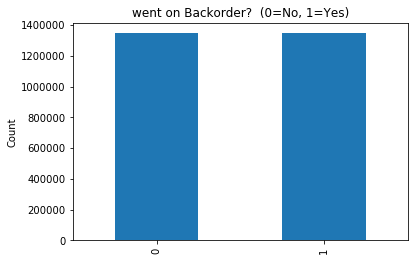

In [195]:
train_no_sku_balx, train_no_sku_baly = SMOTE(train_no_sku_x, train_no_sku_y)  # Balanced Training Data

#### TRAINING THE MODEL

Trained Model :  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


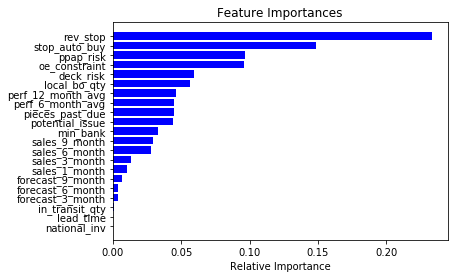

In [169]:
trained_model_plain = Random_Forest_Classifier(train_no_sku_balx, train_no_sku_baly)
print ("Trained Model : ", trained_model_plain)    #To have a look at the classifier parameters   

 #Finding important Features
features = list(train_no_sku.head(0))
importances = trained_model_plain.feature_importances_
indices = np.argsort(importances)
##for i in features:
##    print(i, importances[indices[i]])

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features, rotation = 'horizontal')
plt.xlabel('Relative Importance')
plt.show()


#### EVALUATION METRIC

In [172]:
prediction_plain = trained_model_plain.predict(test_no_sku_x)
print ("Train Accuracy :: ", accuracy_score(train_no_sku_baly, trained_model_plain.predict(train_no_sku_balx)))
print ("Test Accuracy  :: ", accuracy_score(test_no_sku_y, prediction_plain))
print ('roc_auc_score:' , roc_auc_score(test_no_sku_y, prediction_plain))

Train Accuracy ::  0.9969832961029195
Test Accuracy  ::  0.991199314845988
roc_auc_score: 0.7915750005089104


#### ROC_AUC 

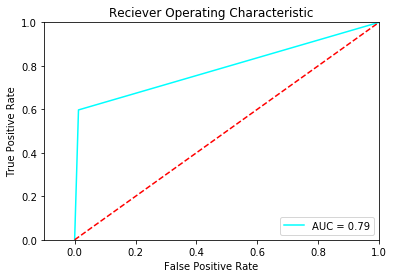

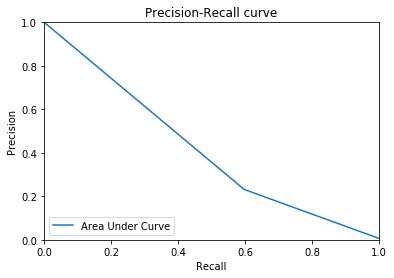

confusion Matrix:: [[332208   4254]
 [   865   1283]]
3053.422880099999 Seconds


In [171]:
#Plotting the ROC curve
roc_curve_acc(Y_test, prediction)  
precision, recall, thresholds = precision_recall_curve(Y_test, prediction)      #Check for errors and accuracy of our model.
area = auc(recall, precision)              # precision is the ratio tp / (tp + fp) ; recall is the ratio tp / (tp + fn)
plt.figure()
plt.plot(recall, precision, label = 'Area Under Curve')             
plt.legend(loc= 'lower left')
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel ('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.show()                  # The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
                            # The recall is intuitively the ability of the classifier to find all the positive samples.
print ('confusion Matrix::' , confusion_matrix(Y_test, prediction))

duration = timer() - start
print (duration, "Seconds")